# Display of the POVM in the Bloch sphere

In this notebook we present the quantum states to discriminate and the evolution of the optimal POVM we propose in the Bloch sphere.

In [1]:
import sys 
sys.path.append('../../')

import itertools
import numpy as np
import qutip
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector
from qiskit.algorithms.optimizers import SPSA
from qiskit import QuantumCircuit, transpile, Aer
from qnn.quantum_neural_networks import StateDiscriminativeQuantumNeuralNetworks as nnd
from qnn.quantum_state import QuantumState 

/home/ruben/.local/lib/python3.8/site-packages/qutip/__init__.py:91: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.14.
  warnings.warn(


In [16]:
def povm(n: int, theta_u: [float], phi_u: [float], lambda_u: [float], theta1: [float], theta2: [float],
         theta_v1: [float], theta_v2: [float], phi_v1: [float], phi_v2: [float], lambda_v1: [float],
         lambda_v2: [float], output='povm'):
    circuit = nnd.get_n_element_povm(n, theta_u, phi_u, lambda_u, theta1, theta2,
                                     theta_v1, theta_v2, phi_v1, phi_v2, lambda_v1,
                                     lambda_v2)
    circuit.save_unitary()

    backend = Aer.get_backend('aer_simulator_unitary')
    circuit = transpile(circuit, backend)
    results = backend.run(circuit).result()

    U = results.get_unitary()

    if output == 'unitary':
        return U
    else:
        U = U.reshape(2 ** (n - 1), 2, 2 ** (n - 1), 2)
        M = []
        for m in range(2 ** (n - 1)):
            if output == 'kraus':
                M.append(U[m, :, 0, :])
            elif output == 'povm':
                M.append(U[m, :, 0, :].T.conj() @ U[m, :, 0, :])

        return M


def get_bloch_vector(operator):
    sx = np.array([[0, 1], [1, 0]])
    sy = np.array([[0, -1j], [1j, 0]])
    sz = np.array([[1, 0], [0, -1]])

    if isinstance(operator, np.ndarray):
        operator = [operator]

    vecs = []
    for O in operator:

        if O.ndim == 1:
            O = np.outer(O, O.T.conj())

        vecs.append([np.real(np.trace(O @ sx)),
                     np.real(np.trace(O @ sy)),
                     np.real(np.trace(O @ sz))])

    return vecs[0] if len(vecs) == 1 else vecs


def callback(params, results, prob_error, prob_inc, prob):
    data.append(params)

In [17]:
backend = Aer.get_backend('aer_simulator_unitary')

ψ = QuantumState([np.array([1, 1]) / np.sqrt(2)])
ϕ = QuantumState([np.array([1, -1]) / np.sqrt(2)])

th_u, fi_u, lam_u = [0], [0], [0]
th1, th2 = [0], [np.pi]
th_v1, th_v2 = [0], [0]
fi_v1, fi_v2 = [0], [0]
lam_v1, lam_v2 = [0], [0]
params = list(itertools.chain(th_u, fi_u, lam_u, th1, th2, th_v1, th_v2, fi_v1, fi_v2, lam_v1, lam_v2))

discriminator = nnd([ψ, ϕ])
data = []
results = discriminator.discriminate(SPSA(100), params, callback=callback)

vec_ψ = get_bloch_vector(ψ.states[0])
vec_ϕ = get_bloch_vector(ϕ.states[0])

/tmp/ipykernel_119658/2221217760.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, azim=-40, elev=30)


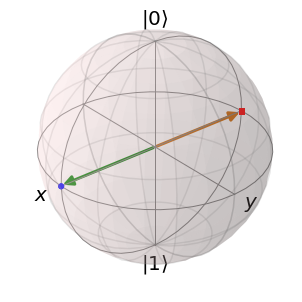

<Figure size 360x360 with 0 Axes>

In [18]:
fig = plt.figure()
ax = Axes3D(fig, azim=-40, elev=30)
sphere = qutip.Bloch(axes=ax)

def animate(i):
    sphere.clear()
    th_u, fi_u, lam_u, th1, th2, th_v1, th_v2, fi_v1, fi_v2, lam_v1, lam_v2 = data[i]
    M = povm(2,
             [th_u], [fi_u], [lam_u],
             [th1], [th2],
             [th_v1], [th_v2],
             [fi_v1], [fi_v2],
             [lam_v1], [lam_v2], output='povm')
    vecs = get_bloch_vector(M)
    sphere.add_points(vec_ψ)
    sphere.add_points(vec_ϕ)
    sphere.add_vectors(vecs[0])
    sphere.add_vectors(vecs[1])
    sphere.make_sphere()
    return ax

ani = animation.FuncAnimation(fig, animate, len(data))
ani.save('bloch_sphere.mp4', fps=20)

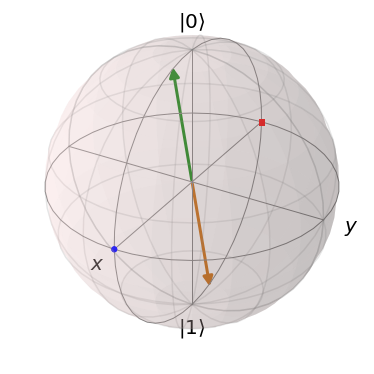

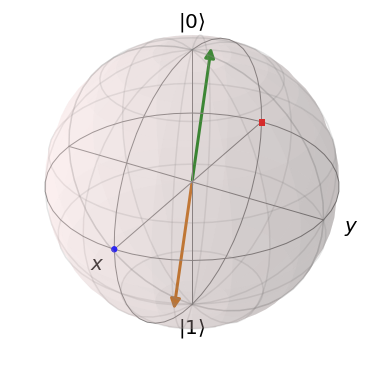

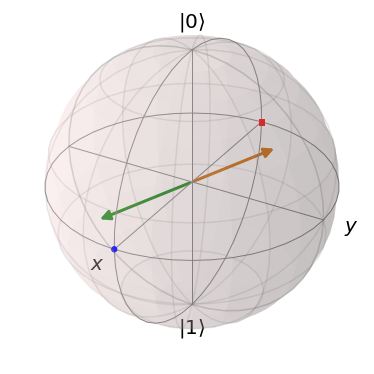

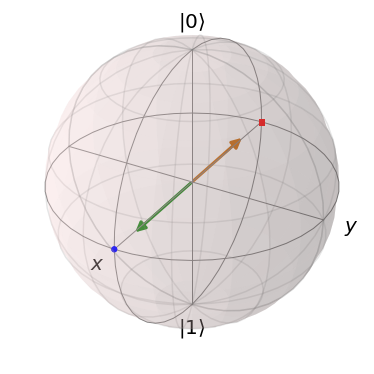

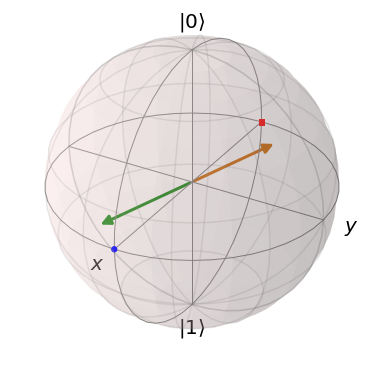

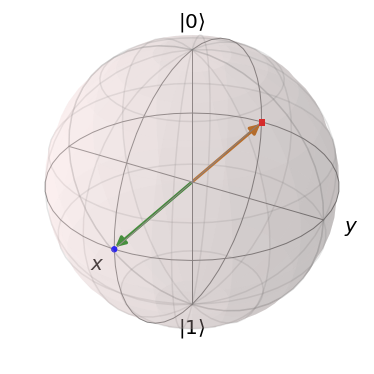

In [19]:
for idex in range(0, len(data), 50):
    th_u, fi_u, lam_u, th1, th2, th_v1, th_v2, fi_v1, fi_v2, lam_v1, lam_v2 = data[idex]
    M = povm(2,
             [th_u], [fi_u], [lam_u],
             [th1], [th2],
             [th_v1], [th_v2],
             [fi_v1], [fi_v2],
             [lam_v1], [lam_v2], output='povm')
    vecs = get_bloch_vector(M)
    b = qutip.Bloch()
    b.add_points(vec_ψ)
    b.add_points(vec_ϕ)
    b.add_vectors(vecs[0])
    b.add_vectors(vecs[1])
    b.render()
    plt.savefig(f'bloch{idex // 50}.png')